# Cross-Section Estimation

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sp
import pandas as pd

import warnings
import tqdm

import pandas_datareader.data as web
import datetime as dt

import statsmodels.api as sm
import linearmodels as lm

import matplotlib.pyplot as plt
import seaborn as sns

import mypack.data as data
import mypack.calc as calc
import mypack.plot as plot
import mypack.clas as clas

In [3]:
pd.set_option('display.float_format', lambda x: '%.4f' % x) #sets decimals to be displayed

In [4]:
sns.set()
sns.set(rc={'figure.figsize': (17, 6)})

In [5]:
%matplotlib inline

## Data

Data is imported from [Kenneth French's data library](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html) and [FRED](https://fred.stlouisfed.org/series/). Currently, this workbook uses 49 industry portfolios and the FF3 factors. Additionally, NBER recession indicators complement the data.

In [6]:
#sample_start = dt.datetime(1962,1,1)
sample_start = dt.datetime(1900,1,1)
sample_end = dt.datetime(2019,5,31)

### Factor data

In [7]:
#factors_daily = data.download_factor_data('D')/100
#factors_monthly = data.download_factor_data('M')/100

#factors_daily = factors_daily.loc[(factors_daily.index >= sample_start) & (factors_daily.index <= sample_end)]
#factors_monthly = factors_monthly.loc[(factors_monthly.index >= sample_start) & (factors_monthly.index <= sample_end)]

### Industry data

In [8]:
industries_daily = data.download_industry_data('D', excessreturns=True)/100
industries_monthly = data.download_industry_data('M', excessreturns=True)/100

In [9]:
industries_monthly = industries_monthly.loc[(industries_monthly.index >= sample_start) & (industries_monthly.index <= sample_end)]
industries_daily = industries_daily.loc[(industries_daily.index >= sample_start) & (industries_daily.index <= sample_end)]

### Recession data

In [10]:
#usrec_daily = data.download_recessions_data('D')
#usrec_monthly = data.download_recessions_data('M')

## Estimation
### Setup

In [11]:
df_xs_estimates = pd.DataFrame(industries_daily.stack().rename(('data','return')))

In [12]:
df_xs_estimates = pd.read_pickle('df_xs_estimates.pkl')

### Moments

In [13]:
win_yrs = 20
moment_name = 'moment_'+str(win_yrs)

In [14]:
# This dictionary contains the mapping of data variables to model outputs for the moment calculations
mom_dict = {'mean': 'y.mean()',
                'std': 'y.std()',
                'var': 'y.var()',
                'skew': 'y.skew()',
                'exkurt': 'y.kurtosis()',
            }

if False:
    # Add data columns to dataframe
    df_xs_estimates = df_xs_estimates.join(pd.DataFrame(np.nan, columns=pd.MultiIndex.from_product([[moment_name], mom_dict.keys()]), index=df_xs_estimates.index))

In [56]:
%%time
for iInd in df_xs_estimates.index.get_level_values(1).unique():
    
    # extract industry data
    df_industry_estimates = df_xs_estimates[(df_xs_estimates.index.get_level_values(1)==iInd)]
    df_industry_estimates.index = df_industry_estimates.index.droplevel('Industry')
    
    # set up indices
    ind_dates = df_industry_estimates[(df_industry_estimates[('data','return')].notna())].index.get_level_values(0)
    opt_dates = ind_dates[ind_dates>ind_dates[0].replace(year=ind_dates[0].year+win_yrs)]
    
    for iDate in tqdm.tqdm(opt_dates):
        
        # select data
        window = ind_dates[(ind_dates>[iDate+dt.timedelta(1) if (iDate.day==29)&(iDate.month==2) else iDate][0].replace(year=iDate.year-win_yrs)) & (ind_dates<=iDate)]
        y = df_industry_estimates.loc[(window),('data','return')]
        
        # estimate & save moments
        for iEntry in mom_dict.keys():
            df_industry_estimates.at[(iDate),('moment', iEntry)] = eval(mom_dict[iEntry])
    
    # save results to main dataframe
    df_xs_estimates.loc[(df_xs_estimates.index.get_level_values(1)==iInd)] = df_industry_estimates.values
            
    print(iInd, list(df_xs_estimates.index.get_level_values(1).unique()).index(iInd)+1,'/',49)
    
df_xs_estimates.to_pickle('df_xs_estimates.pkl')

100%|███████████████████████████████████████████████████████████████████████████| 18537/18537 [01:10<00:00, 261.15it/s]


Agric 1 / 49


100%|███████████████████████████████████████████████████████████████████████████| 18537/18537 [01:08<00:00, 270.28it/s]


Food  2 / 49


100%|███████████████████████████████████████████████████████████████████████████| 18537/18537 [01:05<00:00, 281.32it/s]


Beer  3 / 49


100%|███████████████████████████████████████████████████████████████████████████| 18537/18537 [01:02<00:00, 295.04it/s]


Smoke 4 / 49


100%|███████████████████████████████████████████████████████████████████████████| 18537/18537 [01:00<00:00, 286.60it/s]


Toys  5 / 49


100%|███████████████████████████████████████████████████████████████████████████| 18537/18537 [01:01<00:00, 299.06it/s]


Fun   6 / 49


100%|███████████████████████████████████████████████████████████████████████████| 18537/18537 [01:02<00:00, 296.54it/s]


Books 7 / 49


100%|███████████████████████████████████████████████████████████████████████████| 18537/18537 [01:04<00:00, 286.20it/s]


Hshld 8 / 49


100%|███████████████████████████████████████████████████████████████████████████| 18537/18537 [01:09<00:00, 266.62it/s]


Clths 9 / 49


100%|███████████████████████████████████████████████████████████████████████████| 18537/18537 [01:07<00:00, 273.60it/s]


MedEq 10 / 49


100%|███████████████████████████████████████████████████████████████████████████| 18537/18537 [01:09<00:00, 268.00it/s]


Drugs 11 / 49


100%|███████████████████████████████████████████████████████████████████████████| 18537/18537 [01:04<00:00, 287.41it/s]


Chems 12 / 49


100%|███████████████████████████████████████████████████████████████████████████| 18537/18537 [01:08<00:00, 269.13it/s]


Txtls 13 / 49


100%|███████████████████████████████████████████████████████████████████████████| 18537/18537 [01:07<00:00, 273.24it/s]


BldMt 14 / 49


100%|███████████████████████████████████████████████████████████████████████████| 18537/18537 [01:00<00:00, 307.82it/s]


Cnstr 15 / 49


100%|███████████████████████████████████████████████████████████████████████████| 18537/18537 [00:51<00:00, 362.23it/s]


Steel 16 / 49


100%|███████████████████████████████████████████████████████████████████████████| 18537/18537 [00:56<00:00, 329.36it/s]


Mach  17 / 49


100%|███████████████████████████████████████████████████████████████████████████| 18537/18537 [00:58<00:00, 314.61it/s]


ElcEq 18 / 49


100%|███████████████████████████████████████████████████████████████████████████| 18537/18537 [00:57<00:00, 322.66it/s]


Autos 19 / 49


100%|███████████████████████████████████████████████████████████████████████████| 18537/18537 [00:51<00:00, 356.70it/s]


Aero  20 / 49


100%|███████████████████████████████████████████████████████████████████████████| 18537/18537 [00:54<00:00, 338.28it/s]


Ships 21 / 49


100%|███████████████████████████████████████████████████████████████████████████| 18537/18537 [00:52<00:00, 349.76it/s]


Mines 22 / 49


100%|███████████████████████████████████████████████████████████████████████████| 18537/18537 [00:50<00:00, 382.62it/s]


Coal  23 / 49


100%|███████████████████████████████████████████████████████████████████████████| 18537/18537 [00:58<00:00, 315.17it/s]


Oil   24 / 49


100%|███████████████████████████████████████████████████████████████████████████| 18537/18537 [00:53<00:00, 344.43it/s]


Util  25 / 49


100%|███████████████████████████████████████████████████████████████████████████| 18537/18537 [01:00<00:00, 307.11it/s]


Telcm 26 / 49


100%|███████████████████████████████████████████████████████████████████████████| 18537/18537 [00:46<00:00, 400.88it/s]


BusSv 27 / 49


100%|███████████████████████████████████████████████████████████████████████████| 18537/18537 [00:46<00:00, 396.30it/s]


Hardw 28 / 49


100%|███████████████████████████████████████████████████████████████████████████| 18537/18537 [00:54<00:00, 337.29it/s]


Chips 29 / 49


100%|███████████████████████████████████████████████████████████████████████████| 18537/18537 [01:00<00:00, 305.70it/s]


LabEq 30 / 49


100%|███████████████████████████████████████████████████████████████████████████| 18537/18537 [01:02<00:00, 295.34it/s]


Boxes 31 / 49


100%|███████████████████████████████████████████████████████████████████████████| 18537/18537 [00:54<00:00, 337.65it/s]


Trans 32 / 49


100%|███████████████████████████████████████████████████████████████████████████| 18537/18537 [01:26<00:00, 214.31it/s]


Whlsl 33 / 49


100%|███████████████████████████████████████████████████████████████████████████| 18537/18537 [01:16<00:00, 242.30it/s]


Rtail 34 / 49


100%|███████████████████████████████████████████████████████████████████████████| 18537/18537 [00:51<00:00, 360.43it/s]


Meals 35 / 49


100%|███████████████████████████████████████████████████████████████████████████| 18537/18537 [00:48<00:00, 385.28it/s]


Banks 36 / 49


100%|███████████████████████████████████████████████████████████████████████████| 18537/18537 [00:55<00:00, 332.38it/s]


Insur 37 / 49


100%|███████████████████████████████████████████████████████████████████████████| 18537/18537 [00:59<00:00, 311.97it/s]


RlEst 38 / 49


100%|███████████████████████████████████████████████████████████████████████████| 18537/18537 [00:55<00:00, 331.28it/s]


Fin   39 / 49


100%|███████████████████████████████████████████████████████████████████████████| 18537/18537 [00:52<00:00, 354.25it/s]


Other 40 / 49


100%|███████████████████████████████████████████████████████████████████████████| 18254/18254 [01:03<00:00, 287.56it/s]


PerSv 41 / 49


100%|███████████████████████████████████████████████████████████████████████████| 17688/17688 [01:03<00:00, 279.17it/s]


Paper 42 / 49


100%|███████████████████████████████████████████████████████████████████████████| 17406/17406 [00:47<00:00, 362.64it/s]


Rubbr 43 / 49


100%|█████████████████████████████████████████████████████████████████████████████| 9053/9053 [00:23<00:00, 380.78it/s]


Soda  44 / 49


100%|█████████████████████████████████████████████████████████████████████████████| 9053/9053 [00:23<00:00, 390.76it/s]


FabPr 45 / 49


100%|█████████████████████████████████████████████████████████████████████████████| 9053/9053 [00:23<00:00, 392.08it/s]


Guns  46 / 49


100%|█████████████████████████████████████████████████████████████████████████████| 9053/9053 [00:23<00:00, 389.66it/s]


Gold  47 / 49


100%|█████████████████████████████████████████████████████████████████████████████| 8548/8548 [00:22<00:00, 382.00it/s]


Softw 48 / 49


100%|█████████████████████████████████████████████████████████████████████████████| 7537/7537 [00:19<00:00, 388.75it/s]


Hlth  49 / 49
Wall time: 45min 34s


### HMM: mmss

In [15]:
win_yrs = 20
hmm_name = 'HMM_mmss_'+str(win_yrs)
moment_name = 'moment'#_'+str(win_yrs)

In [16]:
# This dictionary contains the mapping of data variables to model outputs for the unrestricted HMM models
hmm_dict = {'convergence': 'str(hmm_model.mle_retvals[\'converged\'])',
                'likelihood': 'hmm_model.llf',
                'aic': 'hmm_model.aic',
                'bic': 'hmm_model.bic',
                'mu_0': 'hmm_model.params[\'const[0]\']',
                'mu_1': 'hmm_model.params[\'const[1]\']',
                'sigma2_0': 'hmm_model.params[\'sigma2[0]\']',
                'sigma2_1': 'hmm_model.params[\'sigma2[1]\']',
                'p00': 'hmm_model.params[\'p[0->0]\']',
                'p10': 'hmm_model.params[\'p[1->0]\']',
                'mu_0_se': 'hmm_model.bse[\'const[0]\']',
                'mu_1_se': 'hmm_model.bse[\'const[1]\']',
                'sigma2_0_se': 'hmm_model.bse[\'sigma2[0]\']',
                'sigma2_1_se': 'hmm_model.bse[\'sigma2[1]\']',
                'p00_se': 'hmm_model.bse[\'p[0->0]\']',
                'p10_se': 'hmm_model.bse[\'p[1->0]\']',
                'mu_cov': 'hmm_model.cov_params()[\'const[0]\'][\'const[1]\']',
                'sigma2_cov': 'hmm_model.cov_params()[\'sigma2[0]\'][\'sigma2[1]\']',
                'prob_cov': 'hmm_model.cov_params()[\'p[0->0]\'][\'p[1->0]\']',
                'smooth_prob_0': 'hmm_model.smoothed_marginal_probabilities.iloc[-1,0]',
                'smooth_prob_1': 'hmm_model.smoothed_marginal_probabilities.iloc[-1,1]',
                'filt_prob_0': 'hmm_model.filtered_marginal_probabilities.iloc[-1,0]',
                'filt_prob_1': 'hmm_model.filtered_marginal_probabilities.iloc[-1,1]',
                'mean_smooth_prob_0': 'hmm_model.smoothed_marginal_probabilities.iloc[:,0].mean()',
                'mean_smooth_prob_1': 'hmm_model.smoothed_marginal_probabilities.iloc[:,1].mean()',
                'mean_filt_prob_0': 'hmm_model.filtered_marginal_probabilities.iloc[:,0].mean()',
                'mean_filt_prob_1': 'hmm_model.filtered_marginal_probabilities.iloc[:,1].mean()',
                'smooth_prob_innov': 'abs(hmm_model.smoothed_marginal_probabilities.iloc[-1,0]-hmm_model.smoothed_marginal_probabilities.iloc[-2,0])',
                'filt_prob_innov': 'abs(hmm_model.filtered_marginal_probabilities.iloc[-1,0]-hmm_model.filtered_marginal_probabilities.iloc[-2,0])',
                'nobs': 'hmm_model.nobs',
                'algorithm': 'algo',
            }

if False:
    # Add data columns to dataframe
    df_xs_estimates = df_xs_estimates.join(pd.DataFrame(np.nan, columns=pd.MultiIndex.from_product([[hmm_name], hmm_dict.keys()]), index=df_xs_estimates.index))
    df_xs_estimates[(hmm_name,'convergence')] = df_xs_estimates[(hmm_name,'convergence')].astype(object)
    df_xs_estimates[(hmm_name,'algorithm')] = df_xs_estimates[(hmm_name,'algorithm')].astype(object)

In [26]:
%%time
for iInd in df_xs_estimates.index.get_level_values(1).unique():
    
    # extract industry data
    df_industry_estimates = df_xs_estimates[(df_xs_estimates.index.get_level_values(1)==iInd)]
    df_industry_estimates.index = df_industry_estimates.index.droplevel('Industry')
    
    # set up indices
    ind_dates = df_industry_estimates[(df_industry_estimates[('data','return')].notna())].index.get_level_values(0)
    opt_dates = ind_dates[ind_dates>ind_dates[0].replace(year=ind_dates[0].year+win_yrs)]
    
    correction_count = 0
    for iDate in tqdm.tqdm(opt_dates): 
        
        # look up moment estimates for the period
        (m,s) = (df_industry_estimates.at[(iDate),(moment_name, 'mean')], df_industry_estimates.at[(iDate),(moment_name, 'std')])
        
        # select data
        window = ind_dates[(ind_dates>[iDate+dt.timedelta(1) if (iDate.day==29)&(iDate.month==2) else iDate][0].replace(year=iDate.year-win_yrs)) & (ind_dates<=iDate)]
        y = df_industry_estimates.loc[(window),('data','return')]
        y[y<m-2.325*s] = m-2.325*s + 0.1*(y[y<m-2.325*s]-(m-2.325*s))
        y[y>m+2.325*s] = m+2.325*s + 0.1*(y[y<m-2.325*s]-(m+2.325*s))
        
        # set initial guesses for parameters
        m,s = y.mean(),y.std()
        win_init = [0.9,0.1] + [m] + [m] + [(2*s)**2] + [(0.5*s)**2]
        
        # initialise first optimisation
        if (iDate==opt_dates[0]):
            with warnings.catch_warnings():
                warnings.filterwarnings(action="ignore")
                for i in range(0,50): #run 50 iterations on the first data window to ensure first estimate is accurate
                    hmm_model = sm.tsa.MarkovRegression(y, k_regimes=2, exog=None, switching_trend=True, switching_exog=False, switching_variance=True, missing='drop')\
                        .fit(cov_type='robust', start_params=win_init, method='ncg', disp=False)
                    win_init = hmm_model.params
                    if i is 49:
                        hmm_init = win_init
        
        # make state 0 the high volatility state & adjust starting values
        if hmm_model.params['sigma2[0]']<hmm_model.params['sigma2[1]']:
            hmm_init = [1-hmm_init[1], 1-hmm_init[0], hmm_init[2], hmm_init[3], hmm_init[5], hmm_init[4]]
        init = np.asarray(hmm_init)
        if (min(init[0],1-init[0])<0.01) | (min(init[1],1-init[1])<0.01):
            init = 0.9*np.asarray(hmm_init) + 0.1*np.asarray(win_init)
            correction_count += 1

        # estimate & save HMM
        for algo in ['ncg','bfgs','powell','cg','newton']:
            with warnings.catch_warnings():
                warnings.filterwarnings(action="ignore")
                hmm_model = sm.tsa.MarkovRegression(y, k_regimes=2, exog=None, switching_trend=True, switching_exog=False, switching_variance=True, missing='drop')\
                        .fit(cov_type='robust', start_params=init, method=algo, disp=False)
            if (not any(hmm_model.params.isna())):
                hmm_init = hmm_model.params
                for iEntry in hmm_dict.keys():
                    df_industry_estimates.at[(iDate),(hmm_name, iEntry)] = eval(hmm_dict[iEntry])
                break

    # save results to main dataframe
    df_xs_estimates.loc[(df_xs_estimates.index.get_level_values(1)==iInd)] = df_industry_estimates.values
    print(iInd, list(df_xs_estimates.index.get_level_values(1).unique()).index(iInd)+1, '/', 49, ',', correction_count, 'corrections')
    
    df_xs_estimates.to_pickle('df_xs_estimates.pkl')

100%|██████████████████████████████████████████████████████████████████████████| 18537/18537 [4:57:39<00:00,  1.13it/s]


Fun   6 / 49 ,  4690 corrections


100%|██████████████████████████████████████████████████████████████████████████| 18537/18537 [5:18:12<00:00,  1.28it/s]


Books 7 / 49 ,  1096 corrections


100%|██████████████████████████████████████████████████████████████████████████| 18537/18537 [4:43:11<00:00,  1.22it/s]


Hshld 8 / 49 ,  6682 corrections


100%|██████████████████████████████████████████████████████████████████████████| 18537/18537 [8:00:50<00:00,  1.18it/s]


Clths 9 / 49 ,  1302 corrections


100%|██████████████████████████████████████████████████████████████████████████| 18537/18537 [4:21:06<00:00,  1.25it/s]


MedEq 10 / 49 ,  471 corrections


100%|██████████████████████████████████████████████████████████████████████████| 18537/18537 [4:25:10<00:00,  1.27it/s]


Drugs 11 / 49 ,  2831 corrections


100%|██████████████████████████████████████████████████████████████████████████| 18537/18537 [5:42:03<00:00,  1.04s/it]


Chems 12 / 49 ,  4197 corrections


100%|██████████████████████████████████████████████████████████████████████████| 18537/18537 [5:23:25<00:00,  1.17it/s]


Txtls 13 / 49 ,  55 corrections


100%|██████████████████████████████████████████████████████████████████████████| 18537/18537 [4:52:28<00:00,  1.17it/s]


BldMt 14 / 49 ,  685 corrections


100%|██████████████████████████████████████████████████████████████████████████| 18537/18537 [4:40:52<00:00,  1.21it/s]


Cnstr 15 / 49 ,  3260 corrections


100%|██████████████████████████████████████████████████████████████████████████| 18537/18537 [4:53:23<00:00,  1.37s/it]


Steel 16 / 49 ,  3917 corrections


100%|██████████████████████████████████████████████████████████████████████████| 18537/18537 [4:45:01<00:00,  1.20it/s]


Mach  17 / 49 ,  2861 corrections


100%|██████████████████████████████████████████████████████████████████████████| 18537/18537 [5:32:55<00:00,  1.24it/s]


ElcEq 18 / 49 ,  6489 corrections


100%|█████████████████████████████████████████████████████████████████████████| 18537/18537 [14:04:54<00:00,  1.27it/s]


Autos 19 / 49 ,  4252 corrections


100%|██████████████████████████████████████████████████████████████████████████| 18537/18537 [4:43:24<00:00,  1.15it/s]


Aero  20 / 49 ,  7698 corrections


100%|██████████████████████████████████████████████████████████████████████████| 18537/18537 [4:22:06<00:00,  1.22it/s]


Ships 21 / 49 ,  634 corrections


100%|██████████████████████████████████████████████████████████████████████████| 18537/18537 [4:25:35<00:00,  1.14it/s]


Mines 22 / 49 ,  1987 corrections


100%|██████████████████████████████████████████████████████████████████████████| 18537/18537 [4:52:42<00:00,  1.09s/it]


Coal  23 / 49 ,  3330 corrections


100%|██████████████████████████████████████████████████████████████████████████| 18537/18537 [5:19:02<00:00,  1.20it/s]


Oil   24 / 49 ,  6116 corrections


100%|██████████████████████████████████████████████████████████████████████████| 18537/18537 [4:35:46<00:00,  1.16it/s]


Util  25 / 49 ,  0 corrections


100%|██████████████████████████████████████████████████████████████████████████| 18537/18537 [4:39:16<00:00,  1.18it/s]


Telcm 26 / 49 ,  3351 corrections


100%|█████████████████████████████████████████████████████████████████████████| 18537/18537 [13:53:20<00:00,  1.21it/s]


BusSv 27 / 49 ,  1025 corrections


100%|██████████████████████████████████████████████████████████████████████████| 18537/18537 [5:18:19<00:00,  1.24it/s]


Hardw 28 / 49 ,  9249 corrections


100%|██████████████████████████████████████████████████████████████████████████| 18537/18537 [4:48:33<00:00,  1.16it/s]


Chips 29 / 49 ,  8268 corrections


100%|██████████████████████████████████████████████████████████████████████████| 18537/18537 [5:02:26<00:00,  1.19s/it]


LabEq 30 / 49 ,  4079 corrections


100%|██████████████████████████████████████████████████████████████████████████| 18537/18537 [4:44:37<00:00,  1.15it/s]


Boxes 31 / 49 ,  1402 corrections


100%|██████████████████████████████████████████████████████████████████████████| 18537/18537 [4:52:04<00:00,  1.11it/s]


Trans 32 / 49 ,  1876 corrections


100%|██████████████████████████████████████████████████████████████████████████| 18537/18537 [4:52:25<00:00,  1.25it/s]


Whlsl 33 / 49 ,  1365 corrections


100%|██████████████████████████████████████████████████████████████████████████| 18537/18537 [5:27:02<00:00,  1.27s/it]


Rtail 34 / 49 ,  6716 corrections


100%|█████████████████████████████████████████████████████████████████████████| 18537/18537 [15:03:12<00:00,  1.22it/s]


Meals 35 / 49 ,  2171 corrections


100%|██████████████████████████████████████████████████████████████████████████| 18537/18537 [4:14:47<00:00,  1.27it/s]


Banks 36 / 49 ,  392 corrections


100%|██████████████████████████████████████████████████████████████████████████| 18537/18537 [4:19:49<00:00,  1.23it/s]


Insur 37 / 49 ,  1001 corrections


100%|██████████████████████████████████████████████████████████████████████████| 18537/18537 [8:36:52<00:00,  1.07it/s]


RlEst 38 / 49 ,  2572 corrections


100%|██████████████████████████████████████████████████████████████████████████| 18537/18537 [4:44:24<00:00,  1.24s/it]


Fin   39 / 49 ,  1176 corrections


100%|██████████████████████████████████████████████████████████████████████████| 18537/18537 [4:55:49<00:00,  1.16it/s]


Other 40 / 49 ,  2179 corrections


100%|██████████████████████████████████████████████████████████████████████████| 18254/18254 [4:39:44<00:00,  1.14it/s]


PerSv 41 / 49 ,  0 corrections


100%|██████████████████████████████████████████████████████████████████████████| 17688/17688 [4:36:56<00:00,  1.00it/s]


Paper 42 / 49 ,  870 corrections


100%|██████████████████████████████████████████████████████████████████████████| 17406/17406 [4:30:43<00:00,  1.13it/s]


Rubbr 43 / 49 ,  96 corrections


100%|████████████████████████████████████████████████████████████████████████████| 9053/9053 [2:43:19<00:00,  1.14it/s]


Soda  44 / 49 ,  3581 corrections


100%|████████████████████████████████████████████████████████████████████████████| 9053/9053 [2:15:45<00:00,  1.12it/s]


FabPr 45 / 49 ,  0 corrections


100%|████████████████████████████████████████████████████████████████████████████| 9053/9053 [2:22:39<00:00,  1.11s/it]


Guns  46 / 49 ,  1263 corrections


100%|████████████████████████████████████████████████████████████████████████████| 9053/9053 [3:08:58<00:00,  1.87s/it]


Gold  47 / 49 ,  4767 corrections


100%|████████████████████████████████████████████████████████████████████████████| 8548/8548 [2:24:51<00:00,  1.16it/s]


Softw 48 / 49 ,  1162 corrections


100%|████████████████████████████████████████████████████████████████████████████| 7537/7537 [1:49:19<00:00,  1.24it/s]


Hlth  49 / 49 ,  479 corrections
Wall time: 9d 18h 14min 44s


## Evaluation

#### Table

In [28]:
win_yrs = 20
hmm_name = 'HMM_mmss_'+str(win_yrs)
moment_name = 'moment_'#+str(win_yrs)

In [31]:
crit = 1.96
evaluation_table = pd.DataFrame(index=['Total models','Converged','','Ergodic','Aperiodic','','Ergodic (95$\%$)','Aperiodic (95$\%$)','Significant (95$\%$)','','$\mu$ spread significant (95$\%$)','$\sigma^2$ spread significant (95$\%$)'],\
                                columns=['Total','Percentage'])

evaluation_table.loc['Total models','Total'] = df_xs_estimates[hmm_name,'algorithm'].notna().sum()
    
evaluation_table.loc['Converged','Total'] = (df_xs_estimates[hmm_name,'convergence']=='True').sum()
evaluation_table.loc['Converged','Percentage'] = evaluation_table.loc['Converged','Total']/evaluation_table.loc['Total models','Total']

evaluation_table.loc['Ergodic','Total'] = ((df_xs_estimates[hmm_name,'p00']<0.995)&(df_xs_estimates[hmm_name,'p10']>0.005)).sum()
evaluation_table.loc['Ergodic','Percentage'] = evaluation_table.loc['Ergodic','Total']/evaluation_table.loc['Total models','Total']

evaluation_table.loc['Aperiodic','Total'] = ((df_xs_estimates[hmm_name,'p00']>0.005)&(df_xs_estimates[hmm_name,'p10']<0.995)).sum()
evaluation_table.loc['Aperiodic','Percentage'] = evaluation_table.loc['Aperiodic','Total']/evaluation_table.loc['Total models','Total']

evaluation_table.loc['Ergodic (95$\%$)','Total'] = ((((df_xs_estimates[hmm_name,'p00']-1)/df_xs_estimates[hmm_name,'p00_se']).abs()>crit)&(((df_xs_estimates[hmm_name,'p10'])/df_xs_estimates[hmm_name,'p10_se']).abs()>crit)).sum()
evaluation_table.loc['Ergodic (95$\%$)','Percentage'] = evaluation_table.loc['Ergodic (95$\%$)','Total']/evaluation_table.loc['Total models','Total']

evaluation_table.loc['Aperiodic (95$\%$)','Total'] = ((((df_xs_estimates[hmm_name,'p00'])/df_xs_estimates[hmm_name,'p00_se']).abs()>crit)&(((df_xs_estimates[hmm_name,'p10']-1)/df_xs_estimates[hmm_name,'p10_se']).abs()>crit)).sum()
evaluation_table.loc['Aperiodic (95$\%$)','Percentage'] = evaluation_table.loc['Aperiodic (95$\%$)','Total']/evaluation_table.loc['Total models','Total']

evaluation_table.loc['Significant (95$\%$)','Total'] = ((((df_xs_estimates[hmm_name,'p00']-0.5)/df_xs_estimates[hmm_name,'p00_se']).abs()>crit)&(((df_xs_estimates[hmm_name,'p10']-0.5)/df_xs_estimates[hmm_name,'p10_se']).abs()>crit)).sum()
evaluation_table.loc['Significant (95$\%$)','Percentage'] = evaluation_table.loc['Significant (95$\%$)','Total']/evaluation_table.loc['Total models','Total']
    
evaluation_table.loc['$\mu$ spread significant (95$\%$)','Total'] = (((df_xs_estimates[hmm_name,'mu_0']-df_xs_estimates[hmm_name,'mu_1'])/(df_xs_estimates[hmm_name,'mu_0_se']**2 + df_xs_estimates[hmm_name,'mu_0_se']**2 - 2*df_xs_estimates[hmm_name,'mu_cov'])**0.5).abs()>crit).sum()
evaluation_table.loc['$\mu$ spread significant (95$\%$)','Percentage'] = evaluation_table.loc['$\mu$ spread significant (95$\%$)','Total']/evaluation_table.loc['Total models','Total']

evaluation_table.loc['$\sigma^2$ spread significant (95$\%$)','Total'] = (((df_xs_estimates[hmm_name,'sigma2_0']-df_xs_estimates[hmm_name,'sigma2_1'])/(df_xs_estimates[hmm_name,'sigma2_0_se']**2 + df_xs_estimates[hmm_name,'sigma2_0_se']**2 - 2*df_xs_estimates[hmm_name,'sigma2_cov'])**0.5).abs()>crit).sum()
evaluation_table.loc['$\sigma^2$ spread significant (95$\%$)','Percentage'] = evaluation_table.loc['$\sigma^2$ spread significant (95$\%$)','Total']/evaluation_table.loc['Total models','Total']
    
evaluation_table[evaluation_table.isna()] = ''

calc.export_df_to_latex(evaluation_table, 'xs_evaluation_table')

evaluation_table

,Total,Percentage
Total models,847125,
Converged,847125,1.0000
,,
Ergodic,839388,0.9909
Aperiodic,847125,1.0000
,,
Ergodic (95$\%$),616621,0.7279
Aperiodic (95$\%$),846362,0.9991
Significant (95$\%$),844913,0.9974
,,


#### Plots

In [34]:
win_yrs = 20
moment_name = 'moment'#+str(win_yrs)
hmm_name = 'HMM_mmss_'+str(win_yrs)

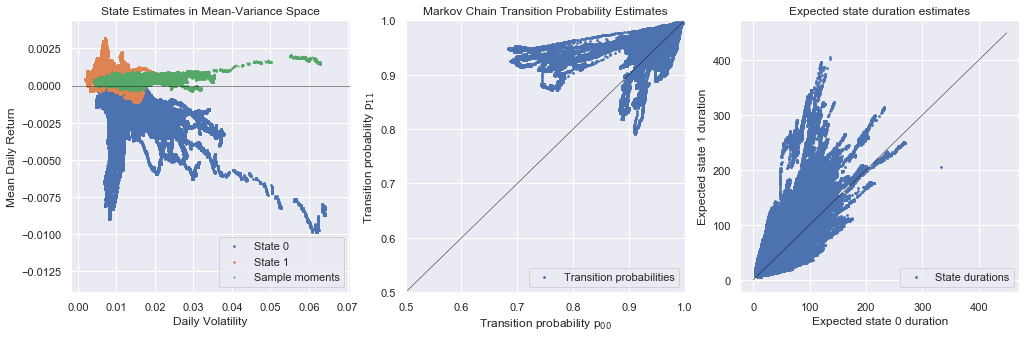

In [36]:
fig, axes = plt.subplots(1,3,figsize=[17,5])

axes[0].axhline(0, color='k', linewidth=0.5)
#axes[0].set_ylim([-0.007,0.003])
#axes[0].set_xlim([0.003,0.016])
axes[0].scatter(df_xs_estimates[(hmm_name,'sigma2_0')]**0.5, df_xs_estimates[(hmm_name,'mu_0')], s=3, label='State 0', rasterized=True)
axes[0].scatter(df_xs_estimates[(hmm_name,'sigma2_1')]**0.5, df_xs_estimates[(hmm_name,'mu_1')], s=3, label='State 1', rasterized=True)
axes[0].scatter(df_xs_estimates[(moment_name,'var')]**0.5, df_xs_estimates[(moment_name,'mean')], s=1, label='Sample moments', rasterized=True)
axes[0].set_xlabel('Daily Volatility')
axes[0].set_ylabel('Mean Daily Return')
axes[0].legend(loc='lower right')
axes[0].set_title('State Estimates in Mean-Variance Space')

axes[1].set_ylim([0.5,1])
axes[1].set_xlim([0.5,1])
axes[1].plot([0,1],[0,1], linewidth=0.5, color='k')
axes[1].scatter(df_xs_estimates[(hmm_name,'p00')], 1-df_xs_estimates[(hmm_name,'p10')], s=3, label='Transition probabilities', rasterized=True)
axes[1].set_xlabel('Transition probability p$_{00}$')
axes[1].set_ylabel('Transition probability p$_{11}$')
axes[1].legend(loc='lower right')
axes[1].set_title('Markov Chain Transition Probability Estimates')

axes[2].plot([0,450],[0,450], linewidth=0.5, color='k')
axes[2].scatter(1/(1-df_xs_estimates[(hmm_name,'p00')]), 1/(df_xs_estimates[(hmm_name,'p10')]), s=3, label='State durations', rasterized=True)
axes[2].set_xlabel('Expected state 0 duration')
axes[2].set_ylabel('Expected state 1 duration')
axes[2].legend(loc='lower right')
axes[2].set_title('Expected state duration estimates')

fig.savefig('XSwindowEstimatesScatterPlot.pdf', format='pdf', dpi=200, bbox_inches='tight')

plt.show()

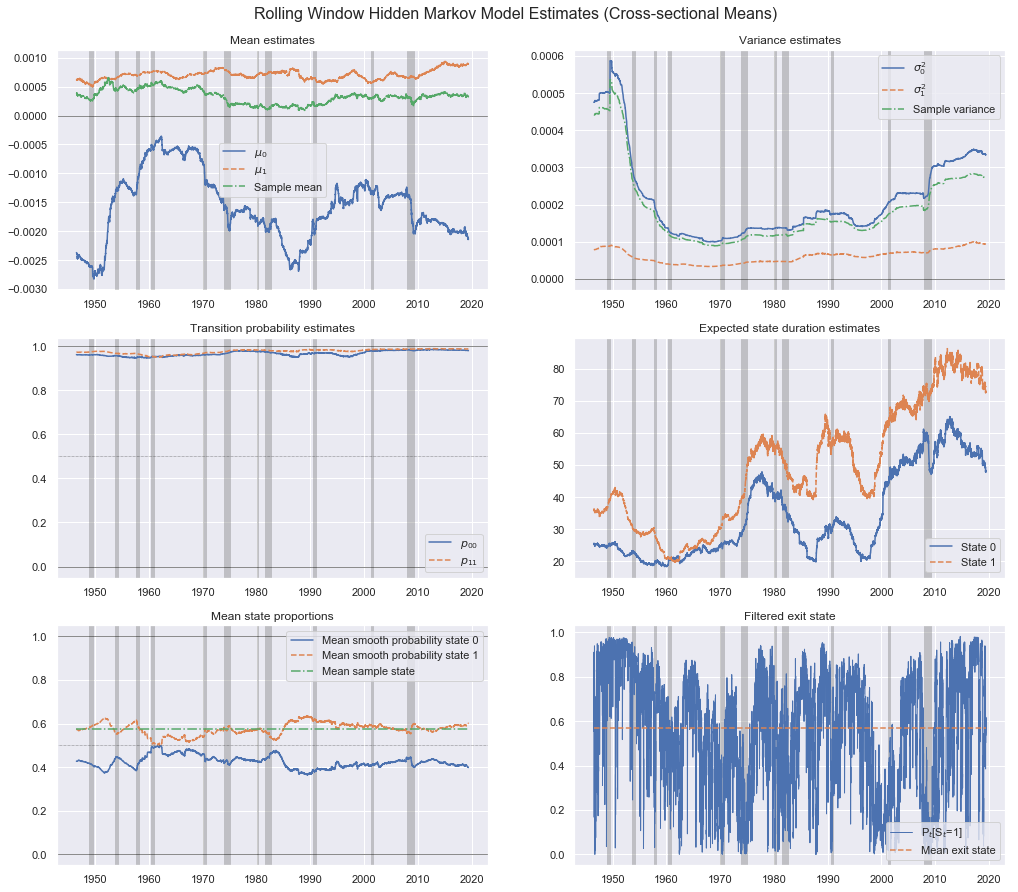

In [63]:
fig, axes = plt.subplots(3,2,figsize=[17,15])

startdate = df_xs_estimates.groupby('Date').head().index.get_level_values(0)[df_xs_estimates.groupby('Date').head()[hmm_name,'mu_0'].notna()][0]
enddate = df_xs_estimates.groupby('Date').head().index.get_level_values(0)[df_xs_estimates.groupby('Date').head()[hmm_name,'mu_0'].notna()][-1]

axes[0,0].plot(df_xs_estimates.groupby('Date').mean()[hmm_name,'mu_0'], label='$\mu_{0}$', rasterized=True)
axes[0,0].plot(df_xs_estimates.groupby('Date').mean()[hmm_name,'mu_1'], label='$\mu_{1}$', linestyle='--', rasterized=True)
axes[0,0].plot(df_xs_estimates.groupby('Date').mean()[moment_name,'mean'], label='Sample mean', linestyle='-.', rasterized=True)
axes[0,0].axhline(0, linewidth=0.5, color='k')
plot.add_recession_bars(axes[0,0], startdate=startdate)
axes[0,0].set_title('Mean estimates')
axes[0,0].legend()

axes[0,1].plot(df_xs_estimates.groupby('Date').mean()[hmm_name,'sigma2_0'], label='$\sigma^2_{0}$', rasterized=True)
axes[0,1].plot(df_xs_estimates.groupby('Date').mean()[hmm_name,'sigma2_1'], label='$\sigma^2_{1}$', linestyle='--', rasterized=True)
axes[0,1].plot(df_xs_estimates.groupby('Date').mean()[moment_name,'var'], label='Sample variance', linestyle='-.', rasterized=True)
axes[0,1].axhline(0, linewidth=0.5, color='k')
plot.add_recession_bars(axes[0,1], startdate=startdate)
axes[0,1].set_title('Variance estimates')
axes[0,1].legend()

axes[1,0].plot(df_xs_estimates.groupby('Date').mean()[hmm_name,'p00'], label='$p_{00}$', rasterized=True)
axes[1,0].plot(1-df_xs_estimates.groupby('Date').mean()[hmm_name,'p10'], label='$p_{11}$', linestyle='--', rasterized=True)
axes[1,0].axhline(0, linewidth=0.5, color='k')
axes[1,0].axhline(1, linewidth=0.5, color='k')
axes[1,0].axhline(0.5, linewidth=0.5, color='k', linestyle=':')
plot.add_recession_bars(axes[1,0], startdate=startdate)
axes[1,0].set_title('Transition probability estimates')
axes[1,0].legend()

axes[1,1].plot(1/(1-df_xs_estimates.groupby('Date').mean()[hmm_name,'p00']), label='State 0', rasterized=True)
axes[1,1].plot(1/(df_xs_estimates.groupby('Date').mean()[hmm_name,'p10']), label='State 1', linestyle='--', rasterized=True)
plot.add_recession_bars(axes[1,1], startdate=startdate)
axes[1,1].set_title('Expected state duration estimates')
axes[1,1].legend()

axes[2,0].plot(df_xs_estimates.groupby('Date').mean()[hmm_name,'mean_prob_0'], label='Mean smooth probability state 0', rasterized=True)
axes[2,0].plot(df_xs_estimates.groupby('Date').mean()[hmm_name,'mean_prob_1'], label='Mean smooth probability state 1', linestyle='--', rasterized=True)
axes[2,0].plot([startdate,enddate],[df_xs_estimates.groupby('Date').mean()[hmm_name,'mean_prob_1'].mean(),df_xs_estimates.groupby('Date').mean()[hmm_name,'mean_prob_1'].mean()]
               , label='Mean sample state', linestyle='-.', rasterized=True)
axes[2,0].axhline(0, linewidth=0.5, color='k')
axes[2,0].axhline(1, linewidth=0.5, color='k')
axes[2,0].axhline(0.5, linewidth=0.5, color='k', linestyle=':')
plot.add_recession_bars(axes[2,0], startdate=startdate)
axes[2,0].set_title('Mean state proportions')
axes[2,0].legend()

axes[2,1].plot(df_xs_estimates.groupby('Date').mean()[hmm_name,'filt_prob_1'], rasterized=True, linewidth=1, label='P$_t$[S$_t$=1]')
axes[2,1].plot([startdate,enddate],[df_xs_estimates.groupby('Date').mean()[hmm_name,'filt_prob_1'].mean(),df_xs_estimates.groupby('Date').mean()[hmm_name,'filt_prob_1'].mean()],
               linestyle='--', label='Mean exit state',  rasterized=True)
plot.add_recession_bars(axes[2,1], startdate=startdate)
axes[2,1].set_title('Filtered exit state')
axes[2,1].legend(loc='lower right')

#axes[2,1].plot(df_market.loc[opt_dates][hmm_name,'nobs'], rasterized=True)
#plot.add_recession_bars(axes[2,1], startdate=opt_dates[0])
#axes[2,1].set_title('Number of observations in '+str(win_yrs)+'-year window')

fig.suptitle('Rolling Window Hidden Markov Model Estimates (Cross-sectional Means)', y=0.92, fontsize=16)

fig.savefig('XSwindowEstimatesResultsPlot.pdf', format='pdf', dpi=200, bbox_inches='tight')

plt.show()

## Results

In [284]:
#df_xs_estimates = pd.read_pickle('df_xs_estimates.pkl')

In [285]:
win_yrs = 20
hmm_name = 'HMM_mmss_'+str(win_yrs)
moment_name = 'moment'#_'+str(win_yrs)

In [334]:
showIndex = 33
iInd = df_xs_estimates.index.get_level_values(1).unique()[showIndex]

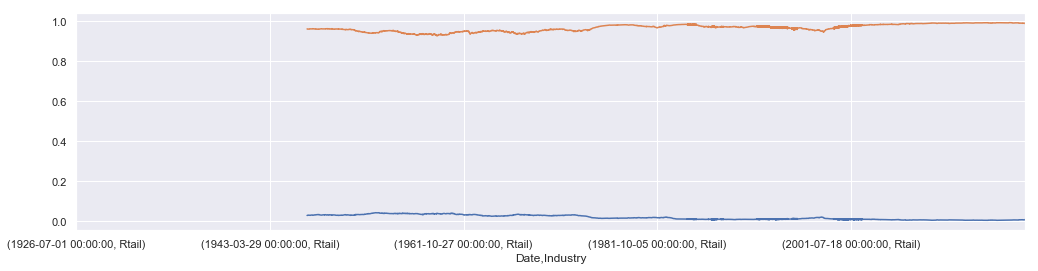

In [335]:
df_xs_estimates[df_xs_estimates.index.get_level_values(1) == iInd][(hmm_name,'p10')].plot(figsize=[17,4])
df_xs_estimates[df_xs_estimates.index.get_level_values(1) == iInd][(hmm_name,'p00')].plot(figsize=[17,4])
plt.show()

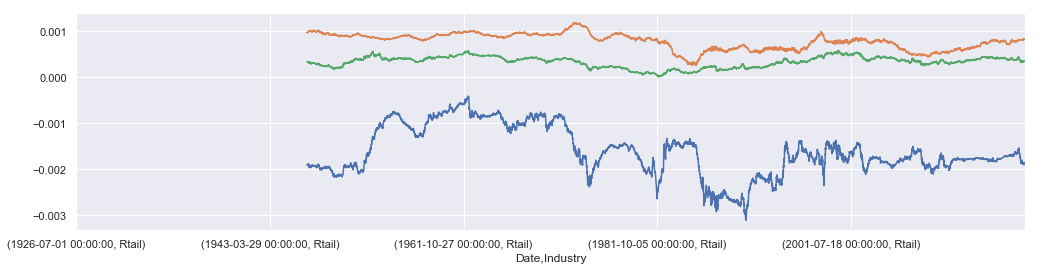

In [336]:
df_xs_estimates[df_xs_estimates.index.get_level_values(1) == iInd][(hmm_name,'mu_0')].plot(figsize=[17,4])
df_xs_estimates[df_xs_estimates.index.get_level_values(1) == iInd][(hmm_name,'mu_1')].plot(figsize=[17,4])
df_xs_estimates[df_xs_estimates.index.get_level_values(1) == iInd][(moment_name,'mean')].plot(figsize=[17,4])
plt.show()

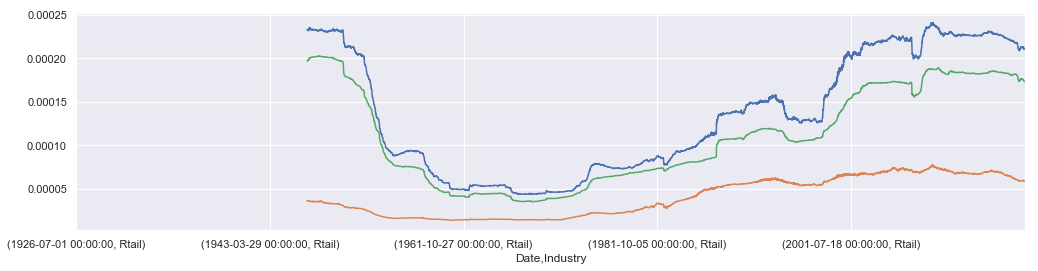

In [337]:
df_xs_estimates[df_xs_estimates.index.get_level_values(1) == iInd][(hmm_name,'sigma2_0')].plot(figsize=[17,4])
df_xs_estimates[df_xs_estimates.index.get_level_values(1) == iInd][(hmm_name,'sigma2_1')].plot(figsize=[17,4])
df_xs_estimates[df_xs_estimates.index.get_level_values(1) == iInd][(moment_name,'var')].plot(figsize=[17,4])
plt.show()

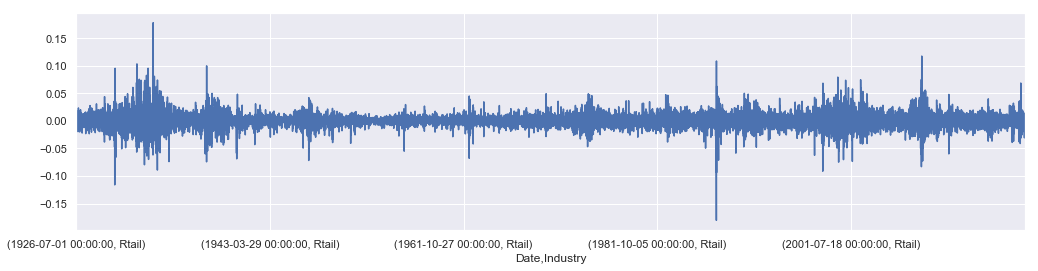

In [338]:
df_xs_estimates[df_xs_estimates.index.get_level_values(1) == iInd][('data','return')].plot(figsize=[17,4])
plt.show()

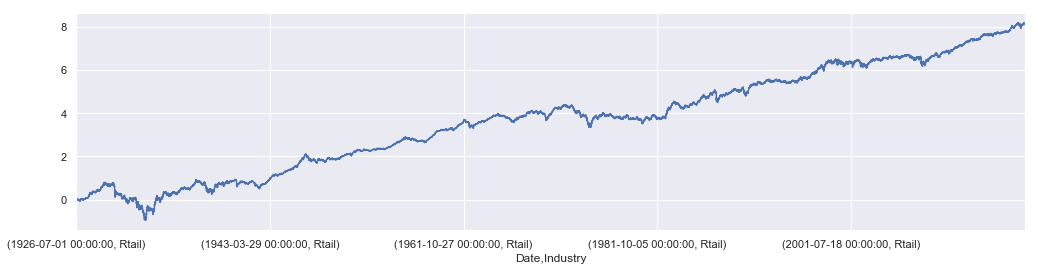

In [339]:
df_xs_estimates[df_xs_estimates.index.get_level_values(1) == iInd][('data','return')].cumsum().plot(figsize=[17,4])
plt.show()

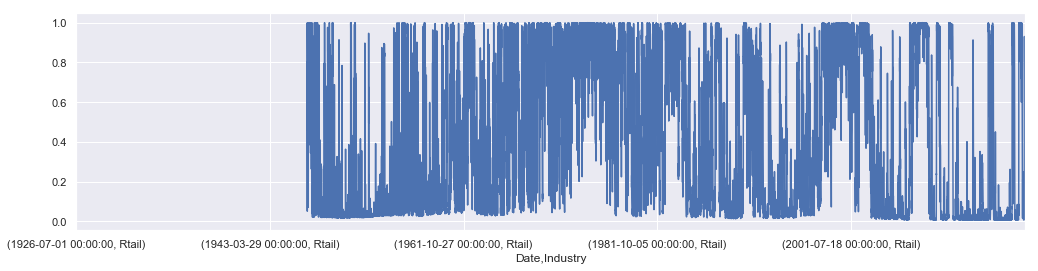

In [340]:
df_xs_estimates[df_xs_estimates.index.get_level_values(1) == iInd][(hmm_name,'filt_prob_0')].plot(figsize=[17,4])
plt.show()

In [341]:
df_xs_estimates[df_xs_estimates.index.get_level_values(1) == iInd][(hmm_name,'filt_prob_0')].mean()

0.39959678862858833

# OLD CODE

### HMM: abss

In [12]:
# This dictionary contains the mapping of data variables to model outputs for the unrestricted HMM models
hmm_dict = {'convergence': 'hmm_model.mle_retvals[\'converged\']',
                'likelihood': 'hmm_model.llf',
                'aic': 'hmm_model.aic',
                'bic': 'hmm_model.bic',
                'alpha': 'hmm_model.params[\'const\']',
                'beta': 'hmm_model.params[\'x1\']',
                'sigma2_0': 'hmm_model.params[\'sigma2[0]\']',
                'sigma2_1': 'hmm_model.params[\'sigma2[1]\']',
                'p00': 'hmm_model.params[\'p[0->0]\']',
                'p10': 'hmm_model.params[\'p[1->0]\']',
                'alpha_se': 'hmm_model.bse[\'const\']',
                'beta_se': 'hmm_model.bse[\'x1\']',
                'sigma2_0_se': 'hmm_model.bse[\'sigma2[0]\']',
                'sigma2_1_se': 'hmm_model.bse[\'sigma2[1]\']',
                'p00_se': 'hmm_model.bse[\'p[0->0]\']',
                'p10_se': 'hmm_model.bse[\'p[1->0]\']',
                'sigma2_cov': 'hmm_model.cov_params()[\'sigma2[0]\'][\'sigma2[1]\']',
                'prob_cov': 'hmm_model.cov_params()[\'p[0->0]\'][\'p[1->0]\']',
                'smooth_prob_0': 'hmm_model.smoothed_marginal_probabilities.iloc[-1,0]',
                'smooth_prob_1': 'hmm_model.smoothed_marginal_probabilities.iloc[-1,1]',
                'filt_prob_0': 'hmm_model.filtered_marginal_probabilities.iloc[-1,0]',
                'filt_prob_1': 'hmm_model.filtered_marginal_probabilities.iloc[-1,1]',
                'mean_prob_0': 'hmm_model.smoothed_marginal_probabilities.iloc[:,0].mean()',
                'mean_prob_1': 'hmm_model.smoothed_marginal_probabilities.iloc[:,1].mean()',
                'smooth_prob_innov': 'abs(hmm_model.smoothed_marginal_probabilities.iloc[-1,0]-hmm_model.smoothed_marginal_probabilities.iloc[-2,0])',
                'filt_prob_innov': 'abs(hmm_model.filtered_marginal_probabilities.iloc[-1,0]-hmm_model.filtered_marginal_probabilities.iloc[-2,0])',
                'nobs': 'hmm_model.nobs',
                'algorithm': 'algo',
            }

if False:
    # Add data columns to dataframe
    df_models = df_models.join(pd.DataFrame(np.nan, columns=pd.MultiIndex.from_product([['HMM_abss'], hmm_dict.keys()]), index=df_models.index))
    df_models[('HMM_abss','convergence')] = None
    df_models[('HMM_abss','convergence')] = df_models[('HMM_abss','convergence')].astype(bool)
    df_models[('HMM_abss','algorithm')] = df_models[('HMM_abss','algorithm')].astype(object)

In [14]:
%%time
for iInd in df_models.index.get_level_values(1).unique():
    
    # set up indices
    ind_dates = df_models[(df_models.index.get_level_values(1)==iInd) & (df_models[('raw_data','return')].notna())].index.get_level_values(0)
    opt_dates = ind_dates[250:]
    
    for iDate in tqdm.tqdm(opt_dates):
        
        # select data
        window = ind_dates[(ind_dates>[iDate+dt.timedelta(1) if (iDate.day==29)&(iDate.month==2) else iDate][0].replace(year=iDate.year-1)) & (ind_dates<=iDate)]
        y = df_models.loc[(window,iInd),('raw_data','return')]
        y.index = y.index.droplevel('Industry')
        x = factors_daily.loc[y.index.get_level_values(0),'Mkt-RF']
        
        # look up OLS estimates for the period & set initial guesses for parameters
            #ols_model = sm.OLS(y, sm.add_constant(x), missing='drop').fit()
            #for iEntry in ols_dict.keys():
            #    df_models.at[(iDate,iInd),('OLS', iEntry)] = eval(ols_dict[iEntry])
        (a,b,s) = (df_models.at[(iDate,iInd),('OLS', 'alpha')],df_models.at[(iDate,iInd),('OLS', 'beta')],df_models.at[(iDate,iInd),('OLS', 'sigma2')])
        ols_init = [0.9,0.1] + [a,b] + [2*s] + [0.5*s]
        
        # initialise first optimisation
        if (iDate==opt_dates[0]):
            with warnings.catch_warnings():
                warnings.filterwarnings(action="ignore")
                for i in range(0,50):
                    hmm_model = sm.tsa.MarkovRegression(y, k_regimes=2, exog=x, switching_trend=False, switching_exog=False, switching_variance=True, missing='drop')\
                        .fit(cov_type='robust', start_params=ols_init, method='ncg', disp=False)
                    hmm_init = hmm_model.params
            
        # make state 0 the high volatility state & adjust starting values
        if hmm_model.params['sigma2[0]']<hmm_model.params['sigma2[1]']:
            hmm_init = [1-hmm_init[1],1-hmm_init[0],hmm_init[2],hmm_init[3],hmm_init[5],hmm_init[4]]
        init = 0.8*np.asarray(hmm_init) + 0.2*np.asarray(ols_init)
        
        # estimate & save HMM
        for algo in ['ncg','bfgs','powell','cg','newton']:
            with warnings.catch_warnings():
                warnings.filterwarnings(action="ignore")
                hmm_model = sm.tsa.MarkovRegression(y, k_regimes=2, exog=x, switching_trend=False, switching_exog=False, switching_variance=True, missing='drop')\
                    .fit(cov_type='robust', start_params=init, method=algo, disp=False)
            if (not any(hmm_model.params.isna())) & (np.abs(hmm_model.params['const']-ols_model.params['const'])<2*ols_model.bse['const']) \
                & (np.abs(hmm_model.params['x1']-ols_model.params['Mkt-RF'])<ols_model.bse['Mkt-RF']):
                hmm_init = hmm_model.params
                for iEntry in hmm_dict.keys():
                    df_models.at[(iDate,iInd),('HMM_abss', iEntry)] = eval(hmm_dict[iEntry])
                break
                
    df_models.to_pickle('df_models.pkl')
    print(iInd, list(df_models.index.get_level_values(1).unique()).index(iInd)+1,'/',49)

100%|██████████████████████████████████████████████████████████████████████████| 14180/14180 [2:07:38<00:00,  3.12it/s]


BusSv 29 / 49


100%|██████████████████████████████████████████████████████████████████████████| 14180/14180 [1:23:53<00:00,  3.12it/s]


Hardw 30 / 49


100%|██████████████████████████████████████████████████████████████████████████| 14180/14180 [1:24:27<00:00,  2.81it/s]


Chips 31 / 49


100%|██████████████████████████████████████████████████████████████████████████| 14180/14180 [1:21:23<00:00,  2.96it/s]


LabEq 32 / 49


100%|██████████████████████████████████████████████████████████████████████████| 14180/14180 [1:14:32<00:00,  3.08it/s]


Paper 33 / 49


100%|██████████████████████████████████████████████████████████████████████████| 14180/14180 [1:13:12<00:00,  3.46it/s]


Boxes 34 / 49


100%|██████████████████████████████████████████████████████████████████████████| 14180/14180 [1:16:15<00:00,  3.08it/s]


Trans 35 / 49


100%|██████████████████████████████████████████████████████████████████████████| 14180/14180 [1:09:17<00:00,  3.38it/s]


Whlsl 36 / 49


100%|██████████████████████████████████████████████████████████████████████████| 14180/14180 [1:16:30<00:00,  3.55it/s]


Rtail 37 / 49


100%|██████████████████████████████████████████████████████████████████████████| 14180/14180 [1:12:12<00:00,  3.27it/s]


Meals 38 / 49


100%|██████████████████████████████████████████████████████████████████████████| 14180/14180 [4:36:47<00:00,  3.57it/s]


Banks 39 / 49


100%|██████████████████████████████████████████████████████████████████████████| 14180/14180 [1:21:50<00:00,  2.39it/s]


Insur 40 / 49


100%|██████████████████████████████████████████████████████████████████████████| 14180/14180 [1:43:01<00:00,  3.13it/s]


RlEst 41 / 49


100%|██████████████████████████████████████████████████████████████████████████| 14180/14180 [2:51:45<00:00,  2.92it/s]


Fin   42 / 49


100%|██████████████████████████████████████████████████████████████████████████| 14180/14180 [1:28:40<00:00,  2.60it/s]


Other 43 / 49


100%|██████████████████████████████████████████████████████████████████████████| 13803/13803 [1:22:17<00:00,  3.28it/s]


Soda  44 / 49


100%|██████████████████████████████████████████████████████████████████████████| 13803/13803 [1:31:36<00:00,  3.06it/s]


FabPr 45 / 49


100%|██████████████████████████████████████████████████████████████████████████| 13803/13803 [1:43:27<00:00,  2.65it/s]


Guns  46 / 49


100%|██████████████████████████████████████████████████████████████████████████| 13803/13803 [2:25:36<00:00,  2.41it/s]


Gold  47 / 49


100%|██████████████████████████████████████████████████████████████████████████| 13299/13299 [1:51:59<00:00,  3.97it/s]


Softw 48 / 49


100%|██████████████████████████████████████████████████████████████████████████| 12320/12320 [1:20:03<00:00,  3.01it/s]


Hlth  49 / 49
Wall time: 1d 12h 3s
